#🙏신용 대출 분석 인공지능 만들기

XGBoost와 Tensorflow를 활용해 실습 데이터를 함께 분석해봅시다!

In [1]:
# 필요한 라이브러리

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

깃허브에 loanData.csv 파일을 업로드 해놨습니다!

마찬가지로 코랩 또는 주피터 사용 시, 작업 중인 폴더에 해당 파일을 이동시켜놓으면 불러오기 편합니다!

In [3]:
loan_data = pd.read_csv('loanData.csv')
loan_data.tail()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
609,LA001350,Male,22,Yes,NaN,Graduate,No,43,13650,56,0.0,1.0,759,Urban,1,2,4000,26,1
610,LA001357,Male,24,NaN,NaN,Graduate,No,62,3816,41,754.0,1.0,3190,Urban,1,2,2880,30,1
611,LA001760,Male,25,NaN,NaN,Graduate,No,86,4758,52,0.0,1.0,1747,Semiurban,1,2,2844,34,1
612,LA002943,Male,67,No,NaN,Graduate,No,12,2987,2,0.0,0.0,0,Semiurban,1,2,1760,30,0
613,LA002393,Female,44,NaN,NaN,Graduate,No,94,10047,43,0.0,1.0,1181,Semiurban,2,1,3712,22,1


여기서 성별(gender) 열이나 부양가족(dependents), 학력(education) 열은 learner가 이해할 수 없는 '문자열' 형식입니다!

보통 머신러닝 모델들은 정수(integer)나 실수(float) 값을 읽고 해석하는데, 610번 회원의 부양가족은 '3+'와 같은 형태로 표시되어 있기 때문에, 아예 NaN 오류가 떠버리네요! 전처리가 필요해보입니다!

In [4]:
loan_data['gender'].unique()

array(['Male', 'Female', nan], dtype=object)

In [5]:
loan_data['age'].unique()

array([55, 68, 43, 22, 34, 37, 57, 52, 31, 38, 33, 50, 42, 64, 21, 20, 44,
       27, 61, 40, 41, 35, 75, 47, 45, 26, 36, 18, 56, 48, 29, 32, 63, 46,
       28, 49, 51, 23, 70, 39, 30, 53, 25, 62, 60, 24, 58, 65, 74, 73, 54,
       71, 69, 19, 17, 72, 66, 67])

In [6]:
loan_data['married'].unique()

array(['Yes', 'No', nan], dtype=object)

In [7]:
loan_data['dependents'].unique()

array(['3+', '2', '1', '0', nan], dtype=object)

In [8]:
loan_data['education'].unique()

array(['Not Graduate', 'Graduate'], dtype=object)

In [9]:
loan_data['self_employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [10]:
loan_data['business_type'].unique()

array([88, 14, 56, 46, 60, 80, 21, 66, 30, 64, 42, 94,  4, 45, 26, 76, 74,
       35, 43, 59, 11, 29, 61, 78, 51, 81, 58, 10, 37, 16, 49, 55, 96, 36,
       83, 68, 70, 63, 13, 65, 86, 85, 40, 73, 41, 31, 24, 93, 27, 15, 97,
       82, 47,  3, 87, 53, 91, 48, 71, 84, 89, 33, 67, 57, 52, 90,  5,  1,
        2, 28, 77, 79, 92, 72, 99, 17, 44, 69, 95, 38, 20, 54, 34,  9,  8,
       50, 18,  6, 19, 62, 23, 32, 75, 98, 12, 22, 25,  7])

In [12]:
loan_data['credit_history'].unique()

array([ 0., nan,  1.])

In [13]:
loan_data['property_area'].unique()

array(['Semiurban', 'Rural', 'Urban'], dtype=object)

관계상 8개 열에 대해서만 unique value들을 확인했습니다!

In [22]:
# 데이터를 정수형 데이터를 매핑

gender_mapping = {'Male': 1, 'Female': 0, np.nan: -1}
married_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
dep_mapping = {'0': 0, '1': 1, '2': 2, '3+': 3, np.nan: -1}
edu_mapping = {'Graduate': 1, 'Not Graduate': 0}
emp_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
prop_mapping = {'Urban': 1, 'Rural': 3, 'Semiurban': 2}

loan_data = loan_data.replace({'gender': gender_mapping,
                               'married': married_mapping,
                               'dependents': dep_mapping,
                               'education': edu_mapping,
                               'self_employed': emp_mapping,
                               'property_area': prop_mapping
                               })

In [25]:
loan_data.head()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,1,55,1,3,0,0,88,4755,51,0.0,0.0,0,2,3,8,2090,0,0
1,LA001864,1,68,1,3,0,0,14,4931,47,0.0,NaN,0,2,3,7,5376,24,0
2,LA002536,1,43,1,3,0,0,56,3095,33,0.0,1.0,1382,3,3,5,3390,33,1
3,LA001264,1,22,1,3,0,1,46,3333,68,2166.0,NaN,0,2,2,5,2600,36,1
4,LA001384,1,34,1,3,0,0,60,2071,60,754.0,1.0,2756,2,2,5,2820,53,0


이제 데이터 클렌징을 마쳤으니, train data와 test data로 데이터를 split 합시다!

In [26]:
# train_test_split

from sklearn.model_selection import train_test_split

# id 제외
X = loan_data.loc[:, 'gender':'loan_term']
y = loan_data.loc[:, 'loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, random_state = 20)

이제 XGBoost로 신용 대출 여부를 판별하는 모델을 만들어 봅시다!

일반적으로 트리 모형이 이산적인 데이터를 분석하는 데 유리하다고 알려져 있습니다! 마침 데이터도 discrete 형태이니 바로 사용해보죠!

In [27]:
model = XGBClassifier(
    booster = 'gbtree',
    objective = 'binary:logistic',
)

model.fit(x_train, y_train)

XGBClassifier()

더 높은 classification 성능을 얻기 위해서 customizing을 더 진행할 수 있지만, 우선 간단한 모델을 작동하게 만드는 게 더 중요하겠죠!

빠르게 모델을 구축하고 검증부터 합시다!

In [29]:
# 모델과 test data로 정확도를 측정

from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):

  # 예측하기
  y_pred = model.predict(x_test)
  predictions = [round(value) for value in y_pred]

  # 평가하기
  accuracy = accuracy_score(y_test, predictions)
  print('Accuracy: %.2f%%' % (accuracy * 100.0))
  return accuracy

calculate_accuracy(model, x_test, y_test)

Accuracy: 84.55%


0.8455284552845529

간단한 모델임에도 84.55%의 정확도를 보이고 있네요! 하지만 이 사실만으로는 모델이 어떻게 학습됐는지 파악할 수 없겠죠!

수치만으로는 이 모델이 어떤 데이터에 취약한지, 어떤 경우에 대출 심사가 빨리 끝날지 알 수 없습니다!

ROC curve나 loss graph를 그려볼 수도 있겠으나, 두 과정 모두 모델 학습이 얼마나 잘 됐는지 또는 되고 있는지를 보여주는 지표일 뿐입니다! 즉, 모델이 각 feature를 해석하는 방식을 설명해주지 않는다는 것이죠!

이제 여기에 Explainability라는 조미료를 뿌릴 차례인 겁니다!

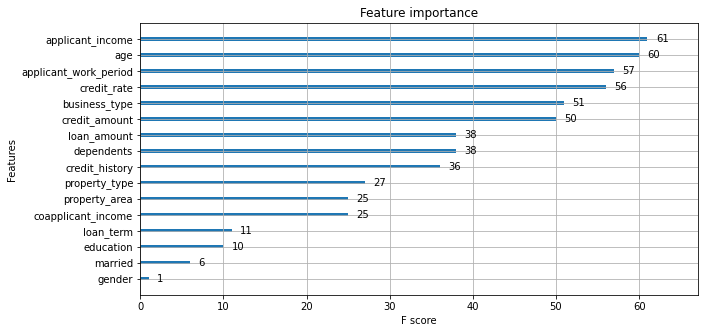

In [30]:
# 피처 중요도

import xgboost
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 5
xgboost.plot_importance(model)

피처 중요도 그래프에 의하면, 대출 승인 여부는 신청자의 수입(applicant income)이 가장 중요하고, 이어서 신용 등급(credit rate)과 나이(age), 대출 신청자 근무 경력(applicant work period) 순으로 중요하네요!

기혼 유무(married)와 최종 학력(education), 성별(gender)은 상대적으로 대출 결정 여부에 큰 영향을 미치지 않는 것으로 보입니다!

하지만, 피처 중요도는 음의 영향력을 표시하지 않습니다!

대출 신청자의 수입이 많으면 대출에 유리할까요, 불리할까요? 이는 상식적인 질문이라 답을 내리기 쉽습니다.

나이는 어떨까요? 나이가 어리면 일할 수 있는 날이 많아서 대출을 갚는 데 유리할 수도 있겠죠. 한편 나이가 많으면 주변에 경제활동을 하는 사람들이 많아서 대리 상환이 가능할 수도 있겠구요. 그렇다면 나이는 적을수록 좋을까요, 많을수록 좋을까요? 음... 아무래도 피처 중요도만으로는 답을 내리기 어려워 보이네요..

그렇다면 SHAP 기법을 사용해봅시다! SHAP는 각 feature의 스케일별 영향력을 계산합니다. SHAP 기법은 outlier에 약하고 sample 계산이 오래 걸린다는 단점이 있지만, 이 데이터는 약 200개의 observation 뿐이고, 금융 데이터는 나름대로 클렌징이 되어 있는 상태입니다. 즉, 이 데이터는 outlier가 적은 것이죠!

SHAP가 가지고 있는 약점을 금융 데이터라는 특수성이 극복하는 형세네요! 따라서 우리는 SHAP 기법을 통해 feature별로 스케일이 변함에 따라 모델에 어떤 영향을 미치는지 쉽게 파악할 수 있을 것입니다!

In [36]:
%tensorflow_version 1.x
%pip install shap

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [37]:
# SHAP 기법으로 사용자 한 명을 분석

import shap

idx = 13

# 13번째 사용자 데이터 출력
print(x_train.iloc[idx, :])

# JS 시각화 라이브러리 불러오기
shap.initjs()

# SHAP 값으로 모델의 예측 결과 설명하기
explainer= shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# 설명자의 해석 결과 출력
shap.force_plot(explainer.expected_value,
                   shap_values[idx, :],
                   x_train.iloc[idx, :])

gender                      1.0
age                        30.0
married                     1.0
dependents                  0.0
education                   1.0
self_employed               0.0
business_type              74.0
applicant_income         1809.0
applicant_work_period      35.0
coapplicant_income       1868.0
credit_history              1.0
credit_amount            3212.0
property_area               1.0
property_type               1.0
credit_rate                 3.0
loan_amount              2520.0
loan_term                  30.0
Name: 498, dtype: float64


이 사용자는 대출 신청이 승인됐네요! (2.50 > 0)

SHAP 분석 결과, 사용자의 신용 등급(3등급)과 나이(30살), 기존 대출 여부가 1건인 항목들이 대출 승인에 크게 긍정적으로 작용했다고 해설합니다! 그리고 비중이 작지만 기존 대출금이 3,212만 원인 것과 대출 신청 금액이 2,520만 원밖에 안 되는 것, 그리고 업종 분류(74: 사업 시설 관리 및 조경 서비스업)가 도움이 됐습니다! 반면 파란색 영역은 대출 심사에 악영향을 미친 부분으로, 대출 신청자 연봉이 1,809만 원이라는 것입니다!

이처럼 SHAP 분석을 사용하면 사용자의 대출 승인 여부를 조목조목 분해할 수 있습니다!

이번에는 explainer 전체를 출력해 봅시다! 이 과정은 대출이 승인 및 거절된 모든 사람의 이력과 점수를 보여줍니다!

In [38]:
shap.initjs()

# 모델이 학습한 결과에 대한 explainer 전체 출력
shap.force_plot(explainer.expected_value, shap_values, x_train)

SHAP로 특정 feature의 영향력을 간단하게 진단해 볼 수도 있습니다!

shap.dependence_plot() 함수는 특정 feature에 대한 분류 영향력을 출력합니다!

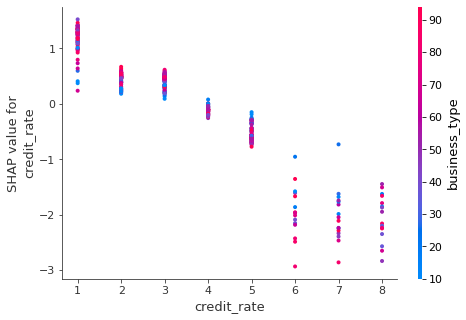

In [39]:
# 신용등급 하나의 feature에 대해 SHAP 영향력을 출력
shap.dependence_plot("credit_rate", shap_values, x_train)

대출 여부가 신용 등급과 느슨한 선형 관계를 갖는다는 것을 알 수 있습니다! 예외가 있긴 하지만, 일반적으로 대출은 5등급보다 높을 때 긍정적인 영향을 미치고, 그 아래 등급에서는 부정적인 영향을 미칩니다!

이제 마지막으로 전체 feature에 대한 규모별 영향력을 한꺼번에 출력해봅시다!

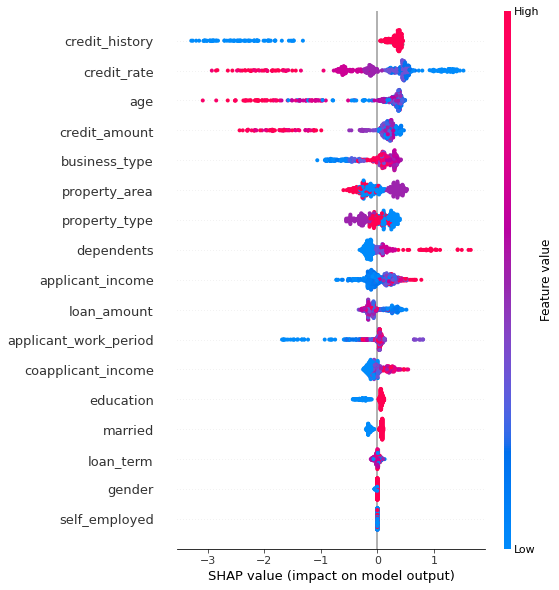

In [40]:
# 모든 feature에 대해 모델이 미치는 영향력 출력
shap.summary_plot(shap_values, x_train)

X축은 대출 신청에 부정적인 요소부터 긍정적인 요소까지 각 요소의 크기를 표시합니다! Y축에는 feature를 모두 나열했습니다!

색깔은 해당 feature의 값이 작아지거나 커질 때의 상황을 표시한 것으로, 나이 feature는 나이가 많을수록 붉은색을 띠며, 적을수록 파란색을 띱니다! 나이가 많을수록 대출 승인이 어려워진다는 것이겠죠! ㅠㅠ

또한 기존 대출이 많은 사람이 대출이 없거나 적은 사람보다 대출에 유리하며, 신용 등급이 높은(숫자가 적은) 사람이 대출 승인 가능성이 높을 것이며, 나이가 어릴수록 대출에 유리하고, 비즈니즈 업종은 숮자가 낮은 쪽(제조, 농업 등)보다 높은 쪽(서비스업 등) 분류가 대출에 유리할 것으로 보입니다! 반면, 자영업 유무나 성별, 대출 기간은 대출 승인에 거의 영향을 미치지 않는다는 점도 확인할 수 있네요!

## 이제 여러분 차례입니다! 여러분 모두 데이터 스토리텔러가 되어 멋진 글을 써보는 겁니다!